In [25]:
# teacher
import ase.visualize as viz
viz.view = lambda atoms, repeat=None: None


# Battery project



## Day 3 - Equilibrium potential



Today you will study the LiFePO$_4$ cathode. You will calculate the equilibrium potential and use Bayesian error estimation to quantify how sensitive the calculated equilibrium potential is towards choice of functional. After today you should be able to discuss:

-  The volume change during charge/discharge.

-  The maximum gravimetric and volumetric energy density of a FePO$_4$/C battery assuming the majority of weight and volume will be given by the electrodes.

-  Uncertainty in the calculations.

Some of calculations you will perform today will be tedious to be run in this notebook. You will automatically submit some calculations to the HPC cluster directly from this notebook. When you have to wait for calculations to finish you can get started on addressing the bullet points above.



## Initialize


In [21]:
%matplotlib notebook
import numpy as np
from ase.visualize import view
import matplotlib.pyplot as plt
from ase.io import read, write, Trajectory
from ase.parallel import paropen
from gpaw import GPAW, FermiDirac, Mixer, PW
from ase.dft.bee import BEEFEnsemble
from ase import Atoms


## FePO$_4$



First we will construct an atoms object for FePO$_4$. ASE can read files from in a large number of different [formats](https://wiki.fysik.dtu.dk/ase/ase/io/io.html?highlight=read%20formats#file-input-and-output). However, in this case you will build it from scratch using the below information:


In [ ]:
# Positions:
# Fe      2.73015081       1.46880951       4.56541172
# Fe      2.23941067       4.40642872       2.14957739
# Fe      7.20997230       4.40642925       0.26615813
# Fe      7.70070740       1.46880983       2.68199421
# O       1.16033403       1.46881052       3.40240205
# O       3.80867172       4.40642951       0.98654342
# O       8.77981469       4.40642875       1.42923946
# O       6.13142032       1.46881092       3.84509827
# O       4.37288562       1.46880982       0.81812712
# O       0.59764596       4.40643021       3.23442747
# O       5.56702590       4.40642886       4.01346264
# O       9.34268360       1.46880929       1.59716233
# O       1.64001691       0.26061277       1.17298291
# O       3.32931769       5.61463705       3.58882629
# O       8.30013707       3.19826250       3.65857000
# O       6.61076951       2.67698811       1.24272700
# O       8.30013642       5.61459688       3.65856912
# O       6.61076982       0.26063178       1.24272567
# O       1.64001666       2.67700652       1.17298270
# O       3.32931675       3.19822249       3.58882660
# P       0.90585688       1.46880966       1.89272372
# P       4.06363530       4.40642949       4.30853266
# P       9.03398503       4.40642957       2.93877879
# P       5.87676435       1.46881009       0.52297232


# Unit cell:
#            periodic     x          y          z    
#   1. axis:    yes    9.94012    0.00000    0.00000
#   2. axis:    yes    0.00000    5.87524    0.00000
#   3. axis:    yes    0.00000    0.00000    4.83157



You *can* use the cell below as a starting point.


In [4]:
# fepo4 = Atoms('Fe4O...',
#               positions=[[x0, y0, z0],[x1, y1, z1]...],
#               cell=[x, y, z],
#               pbc=[True, True, True])

# Teacher:
fepo4 = Atoms('Fe4O16P4',
             positions=[[2.73015081, 1.46880951, 4.56541172],
                [2.23941067, 4.40642872, 2.14957739],
                [7.20997230, 4.40642925, 0.26615813],
                [7.70070740, 1.46880983, 2.68199421],
                [1.16033403, 1.46881052, 3.40240205],
                [3.80867172, 4.40642951, 0.98654342],
                [8.77981469, 4.40642875, 1.42923946],
                [6.13142032, 1.46881092, 3.84509827],
                [4.37288562, 1.46880982, 0.81812712],
                [0.59764596, 4.40643021, 3.23442747],
                [5.56702590, 4.40642886, 4.01346264],
                [9.34268360, 1.46880929, 1.59716233],
                [1.64001691, 0.26061277, 1.17298291],
                [3.32931769, 5.61463705, 3.58882629],
                [8.30013707, 3.19826250, 3.65857000],
                [6.61076951, 2.67698811, 1.24272700],
                [8.30013642, 5.61459688, 3.65856912],
                [6.61076982, 0.26063178, 1.24272567],
                [1.64001666, 2.67700652, 1.17298270],
                [3.32931675, 3.19822249, 3.58882660],
                [0.90585688, 1.46880966, 1.89272372],
                [4.06363530, 4.40642949, 4.30853266],
                [9.03398503, 4.40642957, 2.93877879],
                [5.87676435, 1.46881009, 0.52297232]
                        ],
             cell=[9.94012, 5.87524, 4.83157],
             pbc=[1, 1, 1])


Visualize the structure you have made. Explore the different functions in the visualizer and determine the volume of the cell (`View -> Quick Info`).


In [6]:
view(fepo4)


For better convergence of calculations you should specify initial magnetic moments to iron. The iron will in this structure be Fe$^{3+}$ as it donates two *4s* electrons and one *3d* electron to PO$_4$$^{3-}$. What is the magnetic moment of iron? For simplicity you should assume that FePO$_4$ is ferromagnetic.


In [7]:
# Teacher:
for atom in fepo4:
    if atom.symbol == 'Fe':
        atom.magmom = 5.0  # student: atom.magmom = ?


Now examine the initial magnetic moments of the system using an [appropriate method](https://wiki.fysik.dtu.dk/ase/ase/atoms.html?highlight=get_initial#list-of-all-methods).


In [8]:
magmoms = fepo4.get_initial_magnetic_moments()  # student: magmoms = fepo4.xxx()
print(magmoms)

[5. 5. 5. 5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]



Write your atoms object to file.


In [9]:
write('fepo4.traj', fepo4)


For this calculation you will use the BEEF-vdW functional developed by [Wellendorff et al.](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.85.235149) Although there are better alternatives for calculating the energy of bulk systems, the BEEF-vdW has a build-in ensemble for error estimation of calculated energies. In the set-up of this calculator you will append relevant keyword values into a dictionary, which is inputted the calculator object.


In [10]:
params_GPAW = {}


To save computational time while keeping the calculations physically sound, the following should be used:


In [11]:
params_GPAW['mode']        = PW(500)                      # The used plane wave energy cutoff
params_GPAW['nbands']      = -40                          # The number on empty bands had the system been spin-paired 
params_GPAW['kpts']        = {'size': (2, 4, 5),          # The k-point mesh
                              'gamma': True}
params_GPAW['spinpol']     = True                         # Performing spin polarized calculations
params_GPAW['xc']          = 'BEEF-vdW'                   # The used exchange-correlation functional
params_GPAW['occupations'] = FermiDirac(width=0.1,        # The smearing
                                        fixmagmom=True)   # Total magnetic moment fixed to the initial value
params_GPAW['convergence'] = {'eigenstates': 1.0e-4,      # eV^2 / electron
                              'energy':      2.0e-4,      # eV / electron
                              'density':     1.0e-3}
params_GPAW['mixer']       = Mixer(0.1, 5, weight=100.0)  # The mixer used during SCF optimization



DFT suffers from a so-called self-interaction error. An electron interacts with the system electron density, to which it contributes itself. The error is most pronounced for highly localized orbitals. [Hubbard U correction](https://wiki.fysik.dtu.dk/gpaw/tutorialsexercises/energetics/hubbardu/hubbardu.html) is used to mitigate the self-interaction error of the highly localized *3d*-electrons of Fe. This is done in GPAW using the `setups` keyword.


In [12]:
params_GPAW['setups']      = {'Fe': ':d,4.3'}             # U=4.3 applied to d orbitals



Make a GPAW calculator and attach it to the atoms object. Here you will use [get_potential_energy](https://wiki.fysik.dtu.dk/ase/ase/atoms.html#ase.Atoms.get_potential_energy) to start the calculation.


In [13]:
calc = GPAW(**params_GPAW)
fepo4.calc = calc
epot_fepo4_cell = fepo4.get_potential_energy()
print(epot_fepo4_cell)
write('fepo4_out.traj', fepo4)



  ___ ___ ___ _ _ _  
 |   |   |_  | | | | 
 | | | | | . | | | | 
 |__ |  _|___|_____|  22.1.1b1
 |___|_|             

User:   dft22x019@n-62-27-19
Date:   Sun Aug 14 17:08:20 2022
Arch:   x86_64
Pid:    6358
CWD:    /zhome/fa/5/1000203270/CAMD2022/batteries
Python: 3.8.5
gpaw:   /zhome/fa/5/1000203270/CAMD2022/venv/gpaw/gpaw (4191706c58)
_gpaw:  /zhome/fa/5/1000203270/CAMD2022/venv/gpaw/
        _gpaw.cpython-38-x86_64-linux-gnu.so (88bf7688a8)
ase:    /zhome/fa/5/1000203270/CAMD2022/venv/ase/ase (version 3.23.0b1-bcce2b6c57)
numpy:  /zhome/fa/5/1000203270/CAMD2022/venv/lib/python3.8/site-packages/numpy (version 1.22.4)
scipy:  /zhome/fa/5/1000203270/CAMD2022/venv/lib/python3.8/site-packages/scipy (version 1.8.1)
libxc:  4.3.4
units:  Angstrom and eV
cores: 1
OpenMP: False
OMP_NUM_THREADS: 1

Input parameters:
  convergence: {density: 0.001,
                eigenstates: 0.0001,
                energy: 0.0002}
  kpts: {gamma: True,
         size: (2, 4, 5)}
  mixer: {backend: pulay,


     iter     time        total  log10-change:  magmom
                         energy  eigst   dens
iter:   1 17:14:10  -741.200342                  +19.7103
iter:   2 17:15:30  -730.641320  -1.39  -0.83    +19.7393
iter:   3 17:16:50  -718.941328  -1.09  -0.91    +19.8195
iter:   4 17:18:15  -719.273363  -1.64  -1.24    +19.8741
iter:   5 17:19:33  -721.346838  -1.42  -1.42    +19.9618
iter:   6 17:20:54  -720.061272  -2.04  -1.53    +20.0110
iter:   7 17:22:16  -719.512662  -2.23  -1.85    +19.9971
iter:   8 17:23:44  -719.494752  -3.49  -2.34    +20.0037
iter:   9 17:25:11  -719.485982c -4.33c -2.46    +20.0027
iter:  10 17:26:36  -719.492506c -3.47  -2.61    +20.0008
iter:  11 17:28:05  -719.555351  -3.01  -2.46    +20.0012
iter:  12 17:29:34  -719.488478  -3.45  -2.17    +20.0010
iter:  13 17:31:00  -719.494322  -4.11c -2.90    +20.0006
iter:  14 17:32:32  -719.491150c -5.35c -2.91    +20.0009
iter:  15 17:34:01  -719.491652c -5.24c -3.03c   +20.0011

Converged after 15 iteration


You will use the ensemble capability of the BEEF-vdW functional. You will need this later so you should write it to file so you do not have to start all over again later. Start by obtaining the required data from the calculator, i.e., the individual energy of each term in the BEEF-vdW functional expansion. Get the energy difference compared to BEEF-vdW for 2000 ensemble functionals.


In [15]:
from ase.dft.bee import BEEFEnsemble

ens = BEEFEnsemble(calc)
dE = ens.get_ensemble_energies(2000)


beefvdw ensemble started
beefvdw ensemble finished



Print the energy differences to file. This is not the most efficient way of printing to file but can allow easier subsequent data treatment.


In [16]:
with paropen('ensemble_fepo4.dat', 'a') as result:
    for e in dE:
        print(e, file=result)



You now have what you need to make a full script. Make it in the cell below and execute it to make sure the script runs. Once you have made sure the calculation is able to run, stop it by `interupt the kernel`.


In [51]:
%%writefile 'fepo4.py'
from ase.parallel import paropen
from ase.io import read, write
from ase.dft.bee import BEEFEnsemble
from gpaw import GPAW, FermiDirac, Mixer, PW

# Read in the structure you made and wrote to file above
fepo4 = read('fepo4.traj')

# params_GPAW = {...}

# do calculation ...
# BEEF ...
# write ensemble_fepo4.dat file ...

# write('fepo4_out.traj', fepo4)


# Teacher:
from ase.parallel import paropen
from ase.io import read, write
from ase.io.trajectory import Trajectory
from ase.dft.bee import BEEFEnsemble
from gpaw import GPAW, FermiDirac, Mixer, PW
fepo4 = read('fepo4.traj')

params_GPAW = {}
params_GPAW['mode']        = PW(500)                     #The used plane wave energy cutoff
params_GPAW['nbands']      = -40                           #The number on empty bands had the system been spin-paired
params_GPAW['kpts']        = {'size':  (2,4,5),            #The k-point mesh
                              'gamma': True}
params_GPAW['spinpol']     = True                          #Performing spin polarized calculations
params_GPAW['xc']          = 'BEEF-vdW'                    #The used exchange-correlation functional
params_GPAW['occupations'] = FermiDirac(width = 0.1,      #The smearing
                                        fixmagmom = True)  #Total magnetic moment fixed to the initial value
params_GPAW['convergence'] = {'eigenstates': 1.0e-4,       #eV^2 / electron
                              'energy':      2.0e-4,       #eV / electron
                              'density':     1.0e-3,}
params_GPAW['mixer']       = Mixer(0.1, 5, weight=100.0)   #The mixer used during SCF optimization
params_GPAW['setups']      = {'Fe': ':d,4.3'}              #U=4.3 applied to d orbitals

calc = GPAW(**params_GPAW)
fepo4.calc = calc
epot_fepo4_cell=fepo4.get_potential_energy()
print('E_Pot=', epot_fepo4_cell)

write('fepo4_out.traj', fepo4)

ens = BEEFEnsemble(calc)
dE = ens.get_ensemble_energies(2000)

with paropen('ensemble_fepo4.dat', 'a') as result:
    for e in dE:
        print(e, file=result)

Overwriting fepo4.py



Uncomment the `%%writefile` line and execute the cell again and submit the calculation to the HPC cluster. The calculation should take around 10 minutes.


In [52]:
!mq submit fepo4.py -R 8:1h  # submits the calculation to 8 cores, 1 hour

13909295 ./ fepo4.py 8:1h
1 task submitted



Run the below cell to examine the status of your calculation. If no output is returned, the calculation has either finished or failed.


In [60]:
!mq ls

id       folder name               res.      age state  time error
-------- ------ ------------------ ---- -------- ------ ---- -------------------
13907623 ./     lifepo4.py         8:1h 21:54:35 done   3:58 
13907896 ./     graphite_LDA.py    8:1h 21:11:32 done   2:11 
13908847 ./     intercalation_e.py 8:1h  2:18:21 FAILED 4:41 [n-62-28-28:30527] 
13908851 ./     fepo4.py           8:1h  2:15:50 done   4:05 
13908963 ./     intercalation_e.py 8:1h  1:09:55 FAILED 4:24 [n-62-28-34:28660] 
13909236 ./     fepo4.py           8:1h    19:29 done   3:52 
13909295 ./     fepo4.py           8:1h     4:29 done   4:06 
-------- ------ ------------------ ---- -------- ------ ---- -------------------
done: 5, FAILED: 2, total: 7



Once the calculation begins, you can run the cells below to open the error log and output of the calculation in a new window. This can be done while the calculation is running.


In [54]:
# Error log
!cat "$(ls -t fepo4.py.*err | head -1)"

Modules Release 4.8.0 (2021-07-14)
DCC-SW: Added modules (2021-nov/XeonE5-2660v3)
DCC-SW: Removed standard modules: /apps/dcc/etc/ModulesSL73/modulefiles
DCC-SW: Using gnu/11.2.0 compiler
DCC-SW: Released modules (2021-nov/XeonE5-2660v3)
DCC-SW: Added modules (2020-aug/XeonE5-2660v3)
DCC-SW: Removed standard modules: /apps/dcc/etc/ModulesSL73/modulefiles
DCC-SW: Using gnu/9.3.0 compiler


In [55]:
# Output
!cat "$(ls -t fepo4.py.*out | head -1)"


Once the calculation has finished, load in the result. You can skip past this cell and return later.


In [56]:
try:
    fepo4 = read('fepo4_out.traj')
    print('Calculation finished')
except FileNotFoundError:
    print('Calculation has not yet finished')

Calculation finished



## LiFePO$_4$




You will now do similar for LiFePO$_4$. In this case you will load in a template structure called `lifepo4_wo_li.traj` missing only the Li atoms. It is located in the resources folder.


In [12]:
lifepo4_wo_li = read('lifepo4_wo_li.traj')


Visualize the structure.


In [16]:
view(lifepo4_wo_li)


You should now add Li into the structure using the fractional coordinates below:


In [ ]:
# Li  0    0    0
# Li  0    0.5  0
# Li  0.5  0.5  0.5
# Li  0.5  0    0.5



Add Li atoms into the structure, e.g., by following the example in [this ASE tutorial](https://wiki.fysik.dtu.dk/ase/tutorials/manipulating_atoms.html?highlight=set_cell#manipulating-atoms).


In [4]:
from numpy import identity
from ase import Atom

cell = lifepo4_wo_li.get_cell()

# ...

# lifepo4 = lifepo4_wo_li.copy()

# Teacher:
from numpy import identity
from ase import Atom

lifepo4 = lifepo4_wo_li.copy()
cell = lifepo4.get_cell()
xyzcell = identity(3)
lifepo4.set_cell(xyzcell, scale_atoms=True)  # Set the unit cell and rescale
lifepo4.append(Atom('Li', (0, 0, 0)))
lifepo4.append(Atom('Li', (0, 0.5, 0)))
lifepo4.append(Atom('Li', (0.5, 0.5, 0.5)))
lifepo4.append(Atom('Li', (0.5, 0, 0.5)))
lifepo4.set_cell(cell, scale_atoms=True)


Visualize the structure with added Li.


In [5]:
view(lifepo4)


Ensure that the magnetic moments are as they should be, once again assuming ferromagnetism for simplicity.


In [6]:
# ...

# teacher
print(lifepo4.get_initial_magnetic_moments())

[4. 4. 4. 4. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]



At this point you should save your structure by writing it to a trajectory file.


In [7]:
write('lifepo4.traj', lifepo4)


You should now calculate the potential energy of this sytem using the method and same calculational parameters as for FePO$_4$ above. Make a full script in the cell below similar to what you did above for FePO$_4$ and make sure that it runs.


In [64]:
%%writefile 'lifepo4.py'
from ase.parallel import paropen
from ase.io import read, write
from ase.dft.bee import BEEFEnsemble
from gpaw import GPAW, FermiDirac, Mixer, PW

# Read in the structure you made and wrote to file above
lifepo4 = read('lifepo4.traj')

# params_GPAW = {...}

# ...
# ...
# ...

# write('lifepo4_out.traj', lifepo4)

# teacher
from ase.parallel import paropen
from ase.io import read
from ase.io.trajectory import Trajectory
from ase.dft.bee import BEEFEnsemble
from gpaw import GPAW, FermiDirac, Mixer, PW

#Read in the structure you made and wrote to file above
lifepo4 = read('lifepo4.traj')

params_GPAW = {}
params_GPAW['mode']        = PW(500)                     #The used plane wave energy cutoff
params_GPAW['nbands']      = -40                           #The number on empty bands had the system been spin-paired
params_GPAW['kpts']        = {'size':  (2,4,5),            #The k-point mesh
                              'gamma': True}
params_GPAW['spinpol']     = True                          #Performing spin polarized calculations
params_GPAW['xc']          = 'BEEF-vdW'                    #The used exchange-correlation functional
params_GPAW['occupations'] = FermiDirac(width = 0.1,      #The smearing
                                        fixmagmom = True)  #Total magnetic moment fixed to the initial value
params_GPAW['convergence'] = {'eigenstates': 1.0e-4,       #eV^2 / electron
                              'energy':      2.0e-4,       #eV / electron
                              'density':     1.0e-3,}
params_GPAW['mixer']       = Mixer(0.1, 5, weight=100.0)   #The mixer used during SCF optimization
params_GPAW['setups']      = {'Fe': ':d,4.3'}              #U=4.3 applied to d orbitals

calc = GPAW(**params_GPAW)
lifepo4.calc = calc
epot_lifepo4_cell=lifepo4.get_potential_energy()
print('E_Pot=', epot_lifepo4_cell)

traj=Trajectory('lifepo4_out.traj', mode='w', atoms=lifepo4)
traj.write()

ens = BEEFEnsemble(calc)
dE = ens.get_ensemble_energies(2000)
result = paropen('ensemble_lifepo4.dat','a')
for e in dE:
    print(e, file=result)
result.close()

Overwriting lifepo4.py



If the code runs, submit to the HPC cluster as you did above. The calculation takes approximately 10 minutes.


In [65]:
!mq submit lifepo4.py -R 8:1h  # submits the calculation to 8 cores, 1 hour

13909311 ./ lifepo4.py 8:1h
1 task submitted



Run the below cell to examine the status of your calculation. If no output is returned, the calculation has either finished or failed.


In [70]:
!mq ls

id       folder name               res.      age state  time error
-------- ------ ------------------ ---- -------- ------ ---- -------------------
13907623 ./     lifepo4.py         8:1h 22:01:02 done   3:58 
13907896 ./     graphite_LDA.py    8:1h 21:17:59 done   2:11 
13908847 ./     intercalation_e.py 8:1h  2:24:48 FAILED 4:41 [n-62-28-28:30527] 
13908851 ./     fepo4.py           8:1h  2:22:17 done   4:05 
13908963 ./     intercalation_e.py 8:1h  1:16:22 FAILED 4:24 [n-62-28-34:28660] 
13909236 ./     fepo4.py           8:1h    25:56 done   3:52 
13909295 ./     fepo4.py           8:1h    10:56 done   4:06 
13909311 ./     lifepo4.py         8:1h     4:10 done   4:05 
-------- ------ ------------------ ---- -------- ------ ---- -------------------
done: 6, FAILED: 2, total: 8



Once the calculation begins, you can run the cells below to open the error log and output of the calculation in a new window.


In [12]:
# Error log
!cat "$(ls -t lifepo4.py.*err | head -1)"

Modules Release 4.8.0 (2021-07-14)
DCC-SW: Added modules (2021-nov/XeonE5-2660v3)
DCC-SW: Removed standard modules: /apps/dcc/etc/ModulesSL73/modulefiles
DCC-SW: Using gnu/11.2.0 compiler
DCC-SW: Released modules (2021-nov/XeonE5-2660v3)
DCC-SW: Added modules (2020-aug/XeonE5-2660v3)
DCC-SW: Removed standard modules: /apps/dcc/etc/ModulesSL73/modulefiles
DCC-SW: Using gnu/9.3.0 compiler
DCC-SW: Released modules (2020-aug/XeonE5-2660v3)
Modules Release 4.8.0 (2021-07-14)
DCC-SW: Added modules (2021-nov/XeonE5-2660v3)
DCC-SW: Removed standard modules: /apps/dcc/etc/ModulesSL73/modulefiles
DCC-SW: Using gnu/11.2.0 compiler
DCC-SW: Released modules (2021-nov/XeonE5-2660v3)
DCC-SW: Added modules (2020-aug/XeonE5-2660v3)
DCC-SW: Removed standard modules: /apps/dcc/etc/ModulesSL73/modulefiles
DCC-SW: Using gnu/9.3.0 compiler
DCC-SW: Released modules (2020-aug/XeonE5-2660v3)
Modules Release 4.3.0 (2019-07-26)
DCC-SW: Added modules (2021-nov/XeonE5-2660v3)
DCC-SW: Removed standard modules: /app

In [13]:
# Output
!cat "$(ls -t lifepo4.py.*out | head -1)"

venv: /zhome/fa/5/1000203270/CAMD2022/venv/bin/activate



When calculation has finished, load in the result. You can skip past this cell and return later.


In [17]:
try:
    lifepo4=read('lifepo4_out.traj')
    print('Calculation finished')
except FileNotFoundError:
    print('Calculation has not yet finished')

Calculation finished



### Li metal

We use a Li metal reference to calculate the equilibrium potential. On exercise day 2 you used a Li metal reference to calculate the intercalation energy in the graphite anode. The approach is similar here. Just read in the result of the calculation with DFTD3 and attach a new calulator to it.


In [22]:
from ase import Atoms
from gpaw import GPAW, FermiDirac, PW
from ase.io import read

li_metal = read('Li-metal-DFTD3.traj')  # Change file name accordingly

calc = GPAW(mode=PW(500),
            kpts=(8, 8, 8),
            occupations=FermiDirac(0.15),
            nbands=-10,
            txt=None,
            xc='BEEF-vdW')

li_metal.calc = calc
li_metal.get_potential_energy()
li_metal.write('li_metal.traj')


Now calculate the ensemble in the same way as for FePO$_4$ and LiFePO$_4$.


In [23]:
ens = BEEFEnsemble(calc)
li_metal_ens_cell= ens.get_ensemble_energies(2000)
with paropen('ensemble_li_metal.dat', 'a') as result:
    for e in li_metal_ens_cell:
        print(e, file=result)

beefvdw ensemble started
beefvdw ensemble finished



## Calculate equilibrium potential and uncertainty



You can now calculate the equilibrium potential for the case of a FePO$_4$/Li metal battery from the intercallation energy of Li in FePO$_4$. For simplicity, use that assumption that all vibrational energies and entropic terms cancel each other. You should now have completed all submitted calculations before you proceed.



The calculated energies are for the full cells. Convert them to the energy per formula unit. The [len(...)](https://docs.python.org/3.6/library/functions.html#len) function can be quite helpful for this.


In [71]:
from ase.io import read
fepo4 = read('fepo4_out.traj')
lifepo4=read('lifepo4_out.traj')
li_metal = read('Li-metal-DFTD3.traj')

epot_fepo4_cell=fepo4.get_potential_energy()
epot_lifepo4_cell=lifepo4.get_potential_energy()
epot_li_metal_cell=li_metal.get_potential_energy()
print('epot_fepo4_cell =', epot_fepo4_cell)
print('epot_lifepo4_cell =', epot_lifepo4_cell)
print('epot_li_metal_cell =', epot_li_metal_cell)

epot_fepo4_cell = -719.4916815416422
epot_lifepo4_cell = -756.506569676925
epot_li_metal_cell = -2.020080854238107


In [72]:
epot_fepo4 = epot_fepo4_cell / len(fepo4) * 6  # student: epot_fepo4 = ...
epot_lifepo4 = epot_lifepo4_cell / len(lifepo4) * 7  # student: epot_lifepo4 = ...
epot_li_metal = epot_li_metal_cell / len(li_metal)  # student: epot_li_metal = ...
# print(epot_fepo4, ...)


No calculate the equilibrium potential under the assumption that it is given by $V_{eq} = \Delta U /e $, where $U$ is the electronic potential energy of the system and $e$ is the number of electrons transfered.


In [73]:
# V_eq = ...

# teacher
V_eq = epot_lifepo4 - epot_fepo4 - epot_li_metal
print(V_eq)

-7.233641179582601



You will now calculate the error estimate for the Li intercallation energy in FePO$_4$ using the BEEF ensemble results. Start by loading in the files. Wait a few minutes and rerun the cell if the number is not 2000 for all of them.


In [74]:
import numpy as np
fepo4_ens_cell = np.genfromtxt('ensemble_fepo4.dat')
lifepo4_ens_cell = np.genfromtxt('ensemble_lifepo4.dat')

print('number of functionals in ensemble=', len(fepo4_ens_cell))
print('number of functionals in ensemble=', len(lifepo4_ens_cell))
print('number of functionals in ensemble=', len(li_metal_ens_cell))

number of functionals in ensemble= 2000
number of functionals in ensemble= 2000
number of functionals in ensemble= 2000



Note that these are energies per cell and not per formula unit. Convert them as you did the potential energies above. Note that you are now performing the operation on a list of length 2000 and not a single float value as before.


In [75]:
# fepo4_ens = fepo4_ens_cell / ...
# ...
# ...

# teacher
fepo4_ens = fepo4_ens_cell / len(fepo4) * 6
lifepo4_ens = lifepo4_ens_cell / len(lifepo4) * 7
li_metal_ens = li_metal_ens_cell / len(li_metal)


Make a list of equilibrium potentials.


In [76]:
# V_eq_ens = lifepo4_ens - ...

# teacher
V_eq_ens = lifepo4_ens - fepo4_ens - li_metal_ens


Use the plot command below to visualize the distribution.


<IPython.core.display.Javascript object>


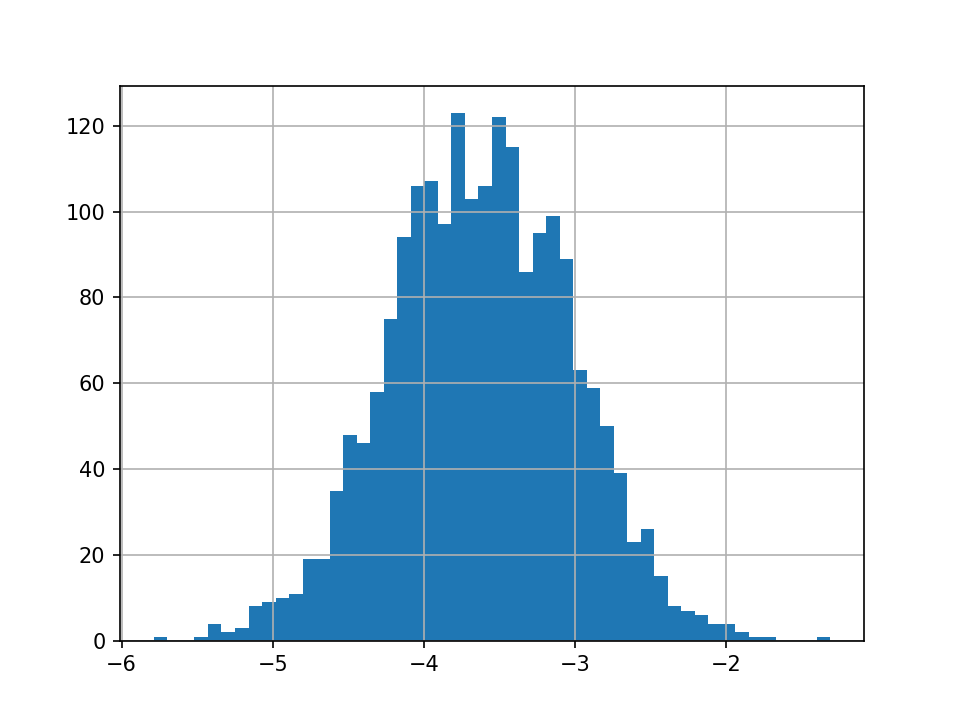

In [77]:
plt.hist(V_eq_ens, 50)
plt.grid(True)


Use the [NumPy function standard deviation function](https://docs.scipy.org/doc/numpy/reference/generated/numpy.std.html#numpy-std) to obtain the standard deviation of the ensemble.


In [78]:
# error = ...
# print(error)

# teacher
error = np.std(V_eq_ens)
print(error)

0.6002060332412464



The equilibrium potential for a FePO$_4$/Li battery is thus as a good estimate:


In [79]:
print(f'{V_eq:.2f} V +- {error:.2f} V')

-7.23 V +- 0.60 V



You can get the equilibrium potential for the FePO$_4$/C battery using the intercallation energy of Li in graphite, that you calculated on Day 2. What equilibrium potential do you find? How does that compare to the cell voltage you can obtain from FePO$_4$/C batteries?


In [ ]:
# You can use this cell for FePO4/C potential calculation


Make sure you are able to discuss the bullet points at the top of this notebook. You can use the cell below for calculations.



## Bonus



How does the predicted error estimate change if you consider the full reaction from Li in graphite + FePO4  to empty graphite + LiFePO4.
